### Comparing KDP from three methods.

In [ ]:
import pyart
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
import fiona
import geopandas as gpd
fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
ERROR 1: PROJ: proj_create_from_database: Open of /ccsopen/home/braut/analysis-env/share/proj failed


#### Select files

In [ ]:
hour = '19'
day = '25'
month = '08'
year = '2022'

files = sorted(glob.glob(f'/gpfs/wolf/atm124/proj-shared/gucxprecipradarS2.00/glue_files/{year}{month}_glued/xprecipradar_guc_volume_{year}{month}{day}-{hour}*'))

radar = pyart.io.read(files[-3])
radar = radar.extract_sweeps([0])

#### Create gatefilter

In [ ]:
nyquist_value = radar.fields['VEL']['data'].max()
vel_texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field='VEL',
                                                        nyq=nyquist_value)

radar.add_field('velocity_texture', vel_texture, replace_existing=True)

phidp_texture = pyart.retrieve.texture_of_complex_phase(radar, phidp_field='PHIDP', phidp_texture_field='phidp_texture')

radar.add_field('phidp_texture', phidp_texture, replace_existing=True)

gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above('phidp_texture', 30)
gatefilter.exclude_above('velocity_texture', 10)


### Compute KDP using  Maesaka method

In [ ]:
kdp, _for_kdp, r_kdp = pyart.retrieve.kdp_maesaka(radar, gatefilter=gatefilter, refl_field='DBZhv',
                                                  psidp_field='PHIDP')
radar.fields['KDP_maesaka']=kdp



/ccsopen/home/braut/analysis-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### KDP using Giangrande method

In [13]:
PHIDP_LP, KDP_LP = pyart.correct.phase_proc_lp(radar, 0.0,
                                                   ncp_field='NCP',
                                                   refl_field='DBZ',
                                                   rhv_field='RHOHV',
                                                   phidp_field='PHIDP')

radar.fields['PHIDP_LP']=PHIDP_LP
radar.fields['KDP_LP']=KDP_LP

/ccsopen/home/braut/analysis-env/lib/python3.10/site-packages/pyart/correct/phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /


In [ ]:
phidp, kdp = pyart.correct.phase_proc_lp_gf(
        radar, gatefilter=kdp_gates, offset=ref_offset, debug=True,
        LP_solver='cylp', nowrap=50, fzl=fzl, self_const=self_const,
        phidp_field=field_config['input_phidp_field'],
        refl_field=field_config['reflectivity'])
    print("Processed phase")
    # We do not use KDP, phase above freezing level
    kdp_gates = copy.deepcopy(cmac_gates)
    kdp_gates.exclude_above('height', fzl)
    phidp_filt, kdp_filt = fix_phase_fields(
        copy.deepcopy(kdp), copy.deepcopy(phidp), radar.range['data'],
        cmac_gates)

    radar.add_field('corrected_differential_phase', phidp,
                    replace_existing=True)

### KDP using Giangrande method (Velocity unfold)

In [6]:
PHIDP_UF = pyart.correct.dealias_unwrap_phase(radar,
                                                   gatefilter=gatefilter,
                                                   skip_checks=True,
                                                   vel_field='PHIDP',
                                                   nyquist_vel=90)
radar.add_field_like('PHIDP', 'PHIDP_UF', PHIDP_UF['data'])


PHIDP_UF_LP, KDP_UF_LP = pyart.correct.phase_proc_lp(radar, 0.0,
                                                   ncp_field='NCP',
                                                   refl_field='DBZ',
                                                   rhv_field='RHOHV',
                                                   phidp_field='PHIDP_UF')
radar.fields['PHIDP_UF_LP']=PHIDP_UF_LP
radar.fields['KDP_UF_LP']=KDP_UF_LP

KeyboardInterrupt: 

### Plots

(-20.0, 20.0)

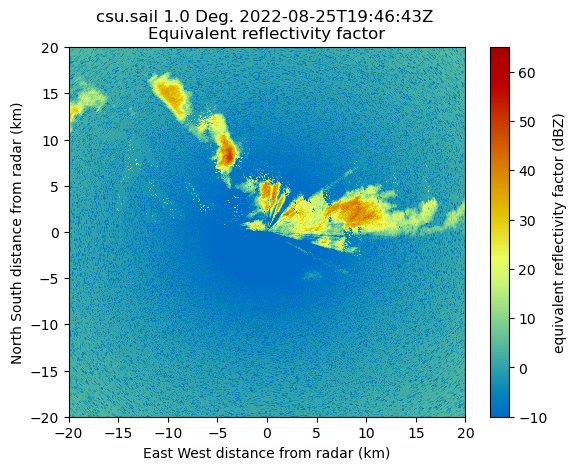

In [7]:
display = pyart.graph.RadarDisplay(radar)
display.plot('DBZ')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

(-20.0, 20.0)

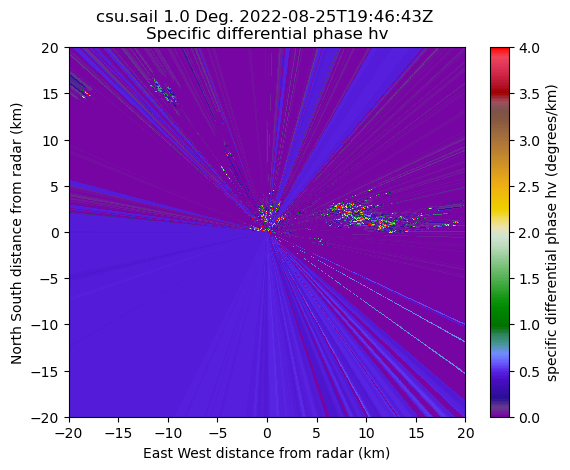

In [8]:
display = pyart.graph.RadarDisplay(radar)
display.plot('KDP_maesaka', vmin=0, vmax=4, cmap='pyart_Carbone42',)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

(-20.0, 20.0)

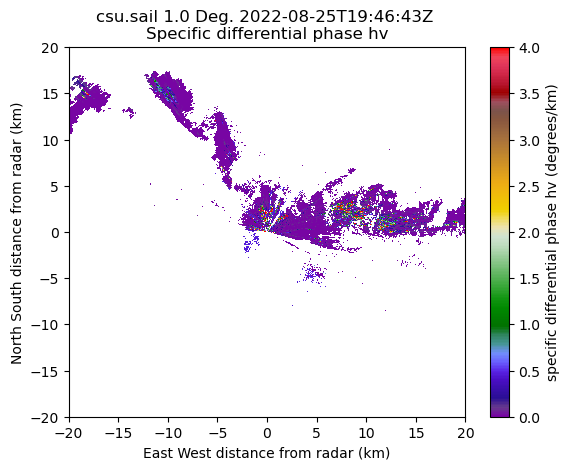

In [12]:
display = pyart.graph.RadarDisplay(radar)
display.plot('KDP_maesaka', gatefilter=gatefilter, vmin=0, vmax=4, cmap='pyart_Carbone42',)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

(-20.0, 20.0)

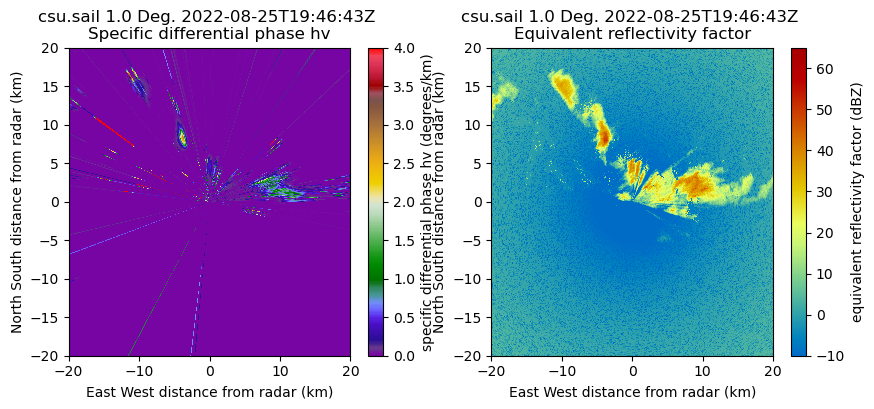

In [24]:
figure = plt.figure(figsize=(10, 4))
ax1=plt.subplot(1, 2, 1)
display = pyart.graph.RadarDisplay(radar)
display.plot('KDP_LP', ax=ax1, vmin=0, vmax=4, cmap='pyart_Carbone42',)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

ax2=plt.subplot(1, 2, 2)
display.plot('DBZ', ax=ax2)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

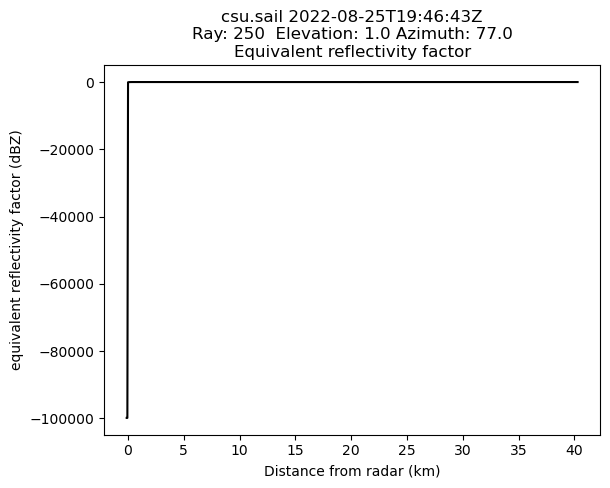

In [40]:
display.plot_ray(ray=250, field='DBZ')

KeyError: 'KDP_UF_LP'

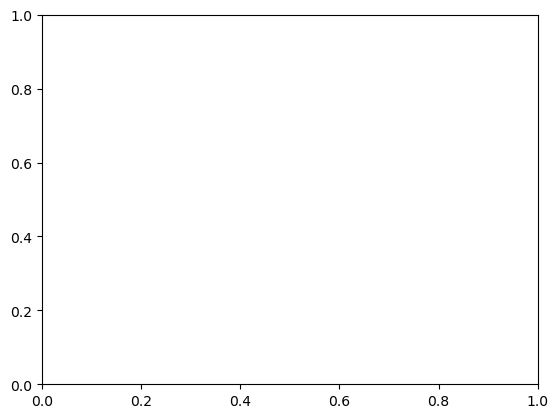

In [10]:
display = pyart.graph.RadarDisplay(radar)
display.plot('KDP_UF_LP', gatefilter=gatefilter, vmin=0, vmax=4, cmap='pyart_Carbone42',)
plt.xlim(-20, 20)
plt.ylim(-20, 20)

In [39]:
pyart.io.write_cfradial(filename='test-pol.nc', radar=radar)

In [ ]:
radar.fields['KDP_maesaka']['data'].max()
plt.hist(radar.fields['KDP_maesaka']['data'].flatten(), bins=50)
plt.xlim(0, 5)

In [ ]:
radar.fields['KDP_LP']['data'].max()
plt.hist(radar.fields['KDP_LP']['data'].flatten(), bins=5000)
plt.xlim(0, 5)

In [ ]:
radar.fields['KDP_UF_LP']['data'].max()
plt.hist(radar.fields['KDP_UF_LP']['data'])
plt.xlim(0, 5)

In [ ]:
plt.scatter(radar.fields['KDP_LP']['data'].flatten(), radar.fields['DBZ']['data'].flatten())
plt.xlim(

In [38]:
list(radar.fields)

['DBZ',
 'VEL',
 'WIDTH',
 'ZDR',
 'PHIDP',
 'RHOHV',
 'NCP',
 'SNR',
 'DBZhv',
 'velocity_texture',
 'phidp_texture',
 'KDP_maesaka',
 'unfolded_differential_phase',
 'PHIDP_LP',
 'KDP_LP',
 'PHIDP_UF']